# Computing a saliency map with the shaping framework


This notebook is an interactive example illustratring the following paper

> Yongchao Xu, Edwin Carlinet, Thierry Géraud, Laurent Najman. Hierarchical Segmentation Using Tree-Based Shape Spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence, Institute of Electrical and Electronics Engineers, 2017, 39 (3), pp.457-469. [⟨10.1109/TPAMI.2016.2554550⟩](https://dx.doi.org/10.1109/TPAMI.2016.2554550). [⟨hal-01301966⟩](https://hal.archives-ouvertes.fr/hal-01301966)


The idea is the following. We build a first hierarchy of components, represented as a tree. We compute some criterion on the components. We transform the tree into a graph, each node of the tree having as neighbors in the graph its parent and its children. We weight the nodes on the graph with the criterion. On this node-weighted graph, we compute a max-tree. We identify the leaves of the max-tree with the most important extinction value, and keep them as the regions we want in the final result. Then we put on the boundaries of each one of these regions their extinction value. The final saliency map is the combination of all those valued boundaries.


In [0]:
%%capture
!pip install ipywidgets
!pip install higra

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import data, img_as_float

from skimage.transform import resize

import higra as hg

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())


Let us choose a simple image.

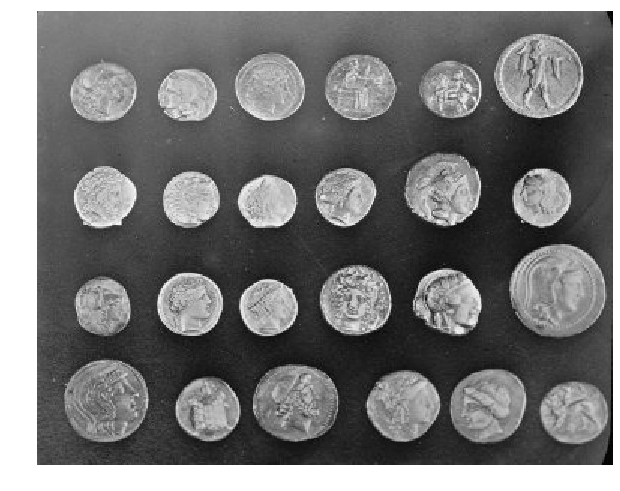

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fcd01d02198>)

In [23]:
image = data.coins()
# switch to float to avoid numerical issue with uint8
image = img_as_float(image)
# discard the color channel (if any)
size = image.shape[:2]
imshow(image, cmap="gray")

We use a 4-adjacency graph on this image.

In [0]:
graph = hg.get_4_adjacency_graph(size)

We need a function that computes the chosen hierarchical tree on the image.

In [0]:
def buildTree(graph, edge_weights=None, areamin=500, tree="BPT"):
    if tree == "BPT":
        # --- Build the BPT
        t1a, altitudesa = hg.bpt_canonical(graph, edge_weights)
        # and remove small regions from it
        t1b, altitudesb = hg.filter_small_nodes_from_tree(t1a, altitudesa, areamin)
        t1, altitudes = hg.canonize_hierarchy(t1b, altitudesb)
        return t1, altitudes
    else:
        if tree == "ToS":    
            t1a, altitudesa = hg.component_tree_tree_of_shapes_image2d(image)
        elif tree == 'maxTree':
            t1a, altitudesa = hg.component_tree_max_tree(graph, image)
        elif tree == "minTree":
            t1a, altitudesa = hg.component_tree_min_tree(graph, image)
        else:
            raise ValueError("Error. Possible choices are BPT, maxTree, minTree or ToS")
        area = hg.attribute_area(t1a)
        condRemoval = area < areamin
        
        t1, node_map = hg.simplify_tree(t1a, condRemoval)
        a1 = altitudesa[node_map]
        return t1, a1
    

Let us now define some attributes. We are going to use circularity, average of the gradient along the contour of the components and compactness.

Circularity is a criterion designed to find disks in images, based on [image moments](https://en.wikipedia.org/wiki/Image_moment). The other criterion are documented in Higra.



In [0]:
# Circularity is 1 for a disk, 0 if not
def circularity(tree):
    g = hg.CptHierarchy.get_leaf_graph(tree)
    size = hg.CptGridGraph.get_shape(g)
    emb = hg.EmbeddingGrid2d(size)
    coord = emb.lin2grid(np.arange(tree.num_leaves()))

    m = np.zeros((tree.num_leaves(), 6), dtype=np.float64)
    m[:, 0] = 1
    m[:, 1] = coord[:, 0]
    m[:, 2] = coord[:, 1]
    m[:, 3] = coord[:, 0] * coord[:, 1]
    m[:, 4] = coord[:, 0] * coord[:, 0]
    m[:, 5] = coord[:, 1] * coord[:, 1]
    m = hg.accumulate_sequential(tree, m, hg.Accumulators.sum)
    m00 = m[:, 0]
    m10 = m[:, 1]
    m01 = m[:, 2]
    m11 = m[:, 3]
    m20 = m[:, 4]
    m02 = m[:, 5]
    xmean = m10 / m00
    ymean = m01 / m00
    xvar = m20 / m00 - xmean * xmean
    yvar = m02 / m00 - ymean * ymean
    xycovar = m11 / m00 - xmean*ymean
    lambda1 = np.maximum(0, 0.5 * (xvar + yvar + np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
    lambda2 = np.maximum(0, 0.5 * (xvar + yvar - np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
    return np.nan_to_num(lambda2[tree.num_leaves():] / lambda1[tree.num_leaves():])

def attribut(tree, attr, edge_weights):
    if attr=="circ":
        attr = circularity(tree)
    elif attr == "averageGradContour":
        attr = hg.attribute_contour_strength(tree, edge_weights)[tree.num_leaves():]
    elif attr == "compactness":
        attr = hg.attribute_compactness(tree, normalize=False)[tree.num_leaves():]
    else:
        print("Error. Attribute not known")
    return attr


Let us put some interaction for the demonstration.

In [29]:
def saliencyShaping(sTree, sAttr, sminArea):  
    global graph

    edge_weights = hg.weight_graph(graph, image, hg.WeightFunction.L2)
    t1, altitudes = buildTree(graph, edge_weights, tree=sTree, areamin=sminArea)
    g = hg.CptHierarchy.get_leaf_graph(t1)
    g_shape = hg.CptGridGraph.get_shape(g)
    edge_weights = hg.weight_graph(g, resize(image, g_shape, anti_aliasing=True), hg.WeightFunction.L2)
    
    attr = attribut(t1, sAttr, edge_weights)
    
    # Now the second tree t2
    sources, targets = t1.edge_list()
    g2 = hg.UndirectedGraph(t1.num_vertices() - t1.num_leaves())
    g2.add_edges(sources[t1.num_leaves():] - t1.num_leaves(), targets[t1.num_leaves():] - t1.num_leaves())
    
    # and compute the max tree
    t2 , a2 = hg.component_tree_max_tree(g2, attr)
    
    # Compute extinction values
    extinction = hg.attribute_dynamics(t2, a2)
    
    # The regions are the extrema of t2
    extrem = hg.attribute_extrema(t2, a2)
    
    extrema_nodes, = np.nonzero(extrem)

    # labelisations of vertices with extrema indices
    node_labels_t2 = np.zeros(t2.num_vertices(), dtype=np.int64)
    node_labels_t2[extrema_nodes] = extrema_nodes
    
    # labelisation of the leaves of t2 (ie, inner nodes of t1) by the index of the extrema they belong to (or 0 if there are not in an extrema)
    extrema_labels_t2 = hg.propagate_sequential(t2,  node_labels_t2, np.logical_not(extrem))[:t2.num_leaves()]
    
    # equivalent labelisation of the inner nodes of t1
    attr_extrema_labels_t1 = np.concatenate((np.zeros(t1.num_leaves(), dtype=np.int64), extrema_labels_t2))
    
    # There may be connected components of t1 with the same labels, we only keep  the largest node of each connected component,
    # ie. the one whose parent has a different label value
    attr_extrema_labels_t1[attr_extrema_labels_t1 == attr_extrema_labels_t1[t1.parents()]] = 0
    
    # we replace non zero labels by the associated extinction value
    representent_nodes, = np.nonzero(attr_extrema_labels_t1)
    nodes_extinction = np.zeros_like(attr_extrema_labels_t1, dtype=np.float64)
    representent_nodes_labels = attr_extrema_labels_t1[representent_nodes]
    nodes_extinction[representent_nodes] = extinction[representent_nodes_labels]
    
    # maximal extinction on contours
    saliency_map = hg.accumulate_on_contours(t1, nodes_extinction, hg.Accumulators.max)
    
    # drawing
    cutKhal = hg.graph_4_adjacency_2_khalimsky(g, saliency_map)
    #imageio.imsave("res.png", cutKhal / np.max(cutKhal))
    imshow(cutKhal, cmap='gray_r')
    return 
  
interact(saliencyShaping, 
         sTree=['ToS', 'BPT', 'maxTree', 'minTree'], 
         sAttr=['averageGradContour', 'compactness', 'circ'],
         sminArea=FloatSlider(min=10, mx=1000, step=10, continuous_update=False))

interactive(children=(Dropdown(description='sTree', options=('ToS', 'BPT', 'maxTree', 'minTree'), value='ToS')…

<function __main__.saliencyShaping>